# Тестовое задание для junior-специалистов по направлению Data Science

## Выполнил: Ворошилов Владислав

Ссылка на django приложение: https://vvspi203.pythonanywhere.com/

Ссылка на репозиторий проекта: https://github.com/VVoroshilov/reviews_rating

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import pickle
from sklearn.datasets import load_svmlight_files
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt 
from xgboost import XGBClassifier
from xgboost import XGBRegressor

#### Укажем пути до обучающей и тестовой выборок

In [163]:
TRAIN_PATH = os.path.join(".", "aclImdb", "train")
TEST_PATH = os.path.join(".", "aclImdb", "test")
subdirs = ["neg", "pos"]

#### Посмотрим пример файла с отзывом. Для этого напишем функцию, которая на выходе даст содержание файла и рейтинг отзыва

In [164]:
def parse_review_file(file_path: str, encoding: str = "utf-8") -> (str, int):
    rating = int(os.path.basename(file_path).split(".")[0].split("_")[1])
    review = None
    with open(file=file_path, mode="r", encoding=encoding) as file:
        review = file.read()
    return review, rating

In [173]:
sample_file_path = os.path.join(TRAIN_PATH, subdirs[0], os.listdir(os.path.join(TRAIN_PATH, subdirs[0]))[0])
sample_file = parse_review_file(sample_file_path)
print(f"Rating: {sample_file[1]}\nContent:\n\t{sample_file[0]}")

Rating: 4
Content:
	Working with one of the best Shakespeare sources, this film manages to be creditable to it's source, whilst still appealing to a wider audience.<br /><br />Branagh steals the film from under Fishburne's nose, and there's a talented cast on good form.


### Авторы статьи приложили к датасету мешок слов и векторизованные отзывы. Далее будем использовать его для построения модели. 

#### Загрузим векторное представление отзывов из .feat файлов, предоставленных авторами. 

In [206]:
## Возьмём готовое векторное представление отзывов, предоставленное авторами датасета
files = [os.path.join(TRAIN_PATH, "labeledBow.feat"),
         os.path.join(TEST_PATH, "labeledBow.feat")]
X_train, y_train, X_test, y_test = load_svmlight_files(files, n_features=None, dtype=np.int64)

#### Выполнил преобразование с помощью tf-idf трансформера для получения полной векторной формы

In [207]:
transformer = TfidfTransformer()

X_train = transformer.fit_transform(X_train)
X_test = transformer.transform(X_test)

#### Считаем мешок слов (.vocab файл), чтобы векторизировать входные данные непосредственно в django приложении

In [13]:
def get_bow(bow_path: str, encoding: str = "utf-8") -> list[str]:
    bow = None
    with open(file=bow_path, mode="r", encoding=encoding) as file:
        bow = file.read()
    return bow.split("\n")

In [178]:
# Часть содержимого мешка слов
bow_path = os.path.join(".", "aclImdb", "imdb.vocab")
get_bow(bow_path)[:10]

['the', 'and', 'a', 'of', 'to', 'is', 'it', 'in', 'i', 'this']

In [208]:
# Объект векторизатор.
vectorizer = TfidfVectorizer(vocabulary=get_bow(bow_path))

In [209]:
# Пример работы
vectorizer.fit_transform(["not bad movie at all ! )"])

<1x89527 sparse matrix of type '<class 'numpy.float64'>'
	with 5 stored elements in Compressed Sparse Row format>

Авторы датасета сообщили, что тестовая и обучающая выборки равны между собой: каждая содержит по 25'000 точек данных. В описании указано, что "негативные" отзывы имеют значение рейтинга на отрезке [1; 4], а "позитивные" имеют рейтинг на отрезке [7; 10]. Посмотрим на распределение рейтинга в обучающей и тестовой выборках. 

Text(0, 0.5, 'Amount')

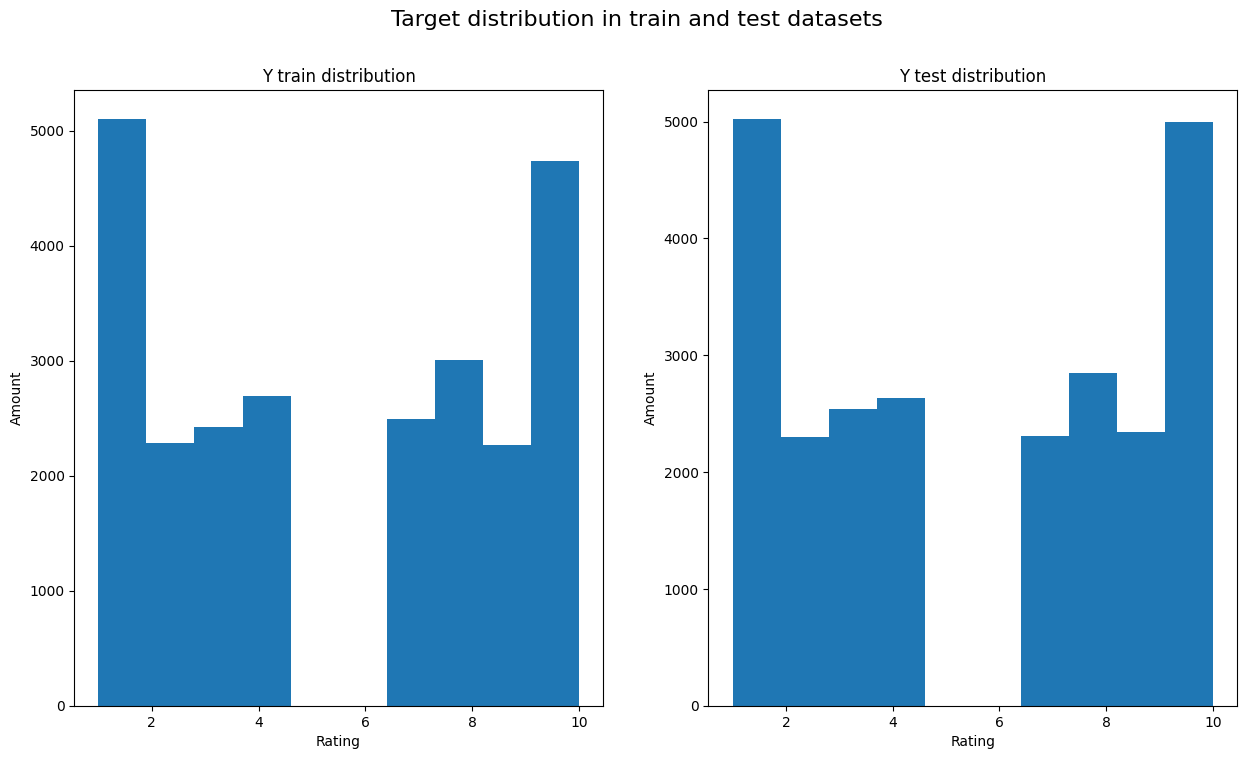

In [192]:
fig = plt.figure(figsize=(15, 8))
ax = fig.subplots(1,2)
fig.suptitle('Target distribution in train and test datasets', fontsize=16)

ax[0].hist(y_train)
ax[0].set_title('Y train distribution')
ax[0].set_xlabel('Rating')
ax[0].set_ylabel('Amount')


ax[1].hist(y_test)
ax[1].set_title('Y test distribution')
ax[1].set_xlabel('Rating')
ax[1].set_ylabel('Amount')

### Выводы по данным: 
Распределения классов в обеих выборках очень похожи между собой. Исключая значения рейтингов 1 и 10, они похожи на нормальное распределение. Рейтинги 1 и 10 наиболее распространённые (по 5000 значений в каждом датасете). В целом, несбалансированности классов не наблюдается. 

### Выбор модели:

Мы имеем дело с табличными данными (т.к. после векторизации с помощью tf-idf трансформера и мешка слов текст будет преобразован в вектор размера 1xBoG_size, где BoG_size - размер мешка слов). Поэтому лучше воспользоваться стандартными методами машинного обучения.

Если мы захотим построить нейронную сеть, то будет необходимо обрабатывать отзывы из датасета без использования авторского мешка слов. Хорошей идеей было бы использовать BERT. 

В своей работе я буду использовать авторский мешок слов, т.к. он собирался с опорой на эмоциальную окраску слов и знаков препинания (например, восклицательный знак). Поэтому будем использовать классические методы ML.

### Задачу выдачи рейтинга отзыву можно рассмотреть двумя способами: классификация и регрессия. 

С классификацией всё тривиально, однако возникает проблема: данные не содержат отзывы с рейтингами 5 и 6, следовательно, обобщающая способность модели будет недостаточно хороша, потому что она не сможет давать предсказания 5 и 6. С другой стороны, тестовая выборка так же не содержит отзывы с рейтингами 5 и 6. Модель будет использоваться в приложении на django, соотвественно будет работать с реальными входными данными, которых нет в выборке. Для данных, ожидаемым результатом для которых является 5 или 6, никто не будет дан верный ответ.

Регрессионная модель будет возвращать вещественное число. Если модели удастся хорошо обобщить обучающие данные, то предсказываемые значения будут находиться вблизи отрезка [1; 10]. Значения <1 можно приравнивать к 1, значения >10 приравнивать к 10. Модель будет возвращать ответ в виде вещественного числа, а классы представляют собой целочисленные значения. Необхоимо будет выбрать вариант интерпретации вывода модели: округление или взятие целой части числа. 

Я бы отдал приоритет использованию регрессионной модели, т.к. с точки зрения обобщения зависимостей в данных она будет иметь возможность спрогнозировать значения 5 и 6, основываясь на весовых коэффициентах для каждого слова в мешке слов.
В исследовательских целях построим классификационные модели, чтобы оценить их результат и сравнить с работой регрессионных моделей.

#### Об обучении:

Т.к. выборка уже поделена на обучающую и тестовую, то кросс-валидация не требуется. Вычисления проводятся на локальной машине, поэтому поиск оптимальных параметров с помощью GridSearch проводиться не будет.

#### Logistic Regression

In [195]:
lReg = LogisticRegression(max_iter=25000)
lReg.fit(X_train, y_train)

LogisticRegression(max_iter=25000)

In [196]:
lReg_pred_train = lReg.predict(X_train)
lReg_pred_test = lReg.predict(X_test)

In [197]:
# Метрики по обучающей выборке
print(classification_report(y_train, lReg_pred_train))

              precision    recall  f1-score   support

         1.0       0.67      0.94      0.78      5100
         2.0       0.90      0.40      0.55      2284
         3.0       0.85      0.55      0.67      2420
         4.0       0.74      0.72      0.73      2696
         7.0       0.78      0.67      0.72      2496
         8.0       0.74      0.68      0.71      3009
         9.0       0.90      0.39      0.55      2263
        10.0       0.64      0.91      0.75      4732

    accuracy                           0.72     25000
   macro avg       0.78      0.66      0.68     25000
weighted avg       0.75      0.72      0.70     25000



In [198]:
# Метрики по тестовой выборке
print(classification_report(y_test, lReg_pred_test))

              precision    recall  f1-score   support

         1.0       0.53      0.83      0.64      5022
         2.0       0.22      0.05      0.08      2302
         3.0       0.28      0.12      0.17      2541
         4.0       0.32      0.35      0.33      2635
         7.0       0.32      0.25      0.28      2307
         8.0       0.27      0.25      0.26      2850
         9.0       0.23      0.04      0.06      2344
        10.0       0.49      0.77      0.60      4999

    accuracy                           0.43     25000
   macro avg       0.33      0.33      0.30     25000
weighted avg       0.37      0.43      0.37     25000



Модель логистической регрессии склонна к переобучению. 

В зависимости от того, какие значения целевой метрики мы ожидаем, можно говорить и о недообученности модели. 

Тривиальный выбор даёт accuracy равное 1/8 = 0.125. В сравнении с тривиальным выбором модель даёт хороший результат.

#### SVM классификация

In [200]:
svc=SVC()
svc.fit(X_train, y_train)

SVC()

In [201]:
svc_pred_train = svc.predict(X_train)
svc_pred_test = svc.predict(X_test)

In [202]:
# Метрики на обучающей выборке 
print(classification_report(y_train, svc_pred_train))

              precision    recall  f1-score   support

         1.0       0.88      1.00      0.93      5100
         2.0       1.00      0.84      0.91      2284
         3.0       0.99      0.91      0.95      2420
         4.0       0.97      0.95      0.96      2696
         7.0       0.97      0.94      0.95      2496
         8.0       0.96      0.93      0.94      3009
         9.0       1.00      0.80      0.89      2263
        10.0       0.88      0.99      0.93      4732

    accuracy                           0.93     25000
   macro avg       0.96      0.92      0.93     25000
weighted avg       0.94      0.93      0.93     25000



In [203]:
# Метрики на тестовой выборке 
print(classification_report(y_test, svc_pred_test))

              precision    recall  f1-score   support

         1.0       0.51      0.85      0.64      5022
         2.0       0.31      0.02      0.03      2302
         3.0       0.27      0.09      0.13      2541
         4.0       0.32      0.37      0.34      2635
         7.0       0.33      0.21      0.25      2307
         8.0       0.28      0.28      0.28      2850
         9.0       0.41      0.01      0.01      2344
        10.0       0.48      0.80      0.60      4999

    accuracy                           0.43     25000
   macro avg       0.36      0.33      0.29     25000
weighted avg       0.39      0.43      0.36     25000



Метод опорных векторов сильно переобучается. На тестовой выборке метрики значительно хуже, при этом классы 2 и 9 имеют практически нулевые метрики.

#### XGBoost Classifier

In [23]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)

In [29]:
xgbc = XGBClassifier(booster="dart")
xgbc.fit(X_train, y_train)

XGBClassifier(base_score=None, booster='dart', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [31]:
# Метрики на обучающей выборке
xgbc_pred_train = xgbc.predict(X_train)
xgbc_report=classification_report(y_train, xgbc_pred_train)
print(xgbc_report)

              precision    recall  f1-score   support

           0       0.89      0.97      0.93      5100
           1       0.99      0.87      0.92      2284
           2       0.99      0.88      0.93      2420
           3       0.96      0.90      0.93      2696
           4       0.96      0.89      0.92      2496
           5       0.93      0.87      0.90      3009
           6       0.98      0.80      0.88      2263
           7       0.79      0.97      0.87      4732

    accuracy                           0.91     25000
   macro avg       0.94      0.89      0.91     25000
weighted avg       0.92      0.91      0.91     25000



In [32]:
# Метрики на тестовой выборке
y_test = le.fit_transform(raw_testing_target)
xgbc_pred_test = xgbc.predict(X_test)
xgbc_report=classification_report(y_test, xgbc_pred_test)
print(xgbc_report)

              precision    recall  f1-score   support

           0       0.51      0.74      0.61      5022
           1       0.19      0.08      0.11      2302
           2       0.23      0.12      0.16      2541
           3       0.30      0.25      0.27      2635
           4       0.28      0.21      0.24      2307
           5       0.24      0.22      0.23      2850
           6       0.20      0.08      0.11      2344
           7       0.45      0.71      0.55      4999

    accuracy                           0.39     25000
   macro avg       0.30      0.30      0.28     25000
weighted avg       0.34      0.39      0.35     25000



Градиентный бустинг сильно переобучается. Как и на предыдущих моделях, метрики для классов 1 и 10 значительно лучше, чем для других классов. 

#### RandomForest

In [254]:
clf_forest = RandomForestClassifier(n_estimators = 300, criterion="log_loss")
clf_forest.fit(X_train, y_train)

RandomForestClassifier(criterion='log_loss', n_estimators=300)

In [255]:
print(classification_report(y_test, clf_forest.predict(X_test)))

              precision    recall  f1-score   support

         1.0       0.37      0.91      0.53      5022
         2.0       0.88      0.01      0.01      2302
         3.0       0.67      0.01      0.02      2541
         4.0       0.37      0.03      0.05      2635
         7.0       0.31      0.02      0.05      2307
         8.0       0.27      0.07      0.11      2850
         9.0       1.00      0.00      0.01      2344
        10.0       0.36      0.84      0.50      4999

    accuracy                           0.37     25000
   macro avg       0.53      0.24      0.16     25000
weighted avg       0.49      0.37      0.23     25000



In [256]:
print(classification_report(y_train, clf_forest.predict(X_train)))

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00      5100
         2.0       1.00      1.00      1.00      2284
         3.0       1.00      1.00      1.00      2420
         4.0       1.00      1.00      1.00      2696
         7.0       1.00      1.00      1.00      2496
         8.0       1.00      1.00      1.00      3009
         9.0       1.00      1.00      1.00      2263
        10.0       1.00      1.00      1.00      4732

    accuracy                           1.00     25000
   macro avg       1.00      1.00      1.00     25000
weighted avg       1.00      1.00      1.00     25000



Случайный лес очень сильно переобучается.

Заметим, что модели либо склонны к сильному переобучению (метрики на обучающей выборке показывают очень высокие значения, чего нельзя сказать о метриках на тестовой выборке), либо к недообучению (метрики низкие на обехи выборках). Но есть и другая особенность: если модель получила на вход отзыв, состоящий из отсутствующих в BoG (bag of words) слов, то она возвращает значение 10. Такое поведение точно не является хорошим подходом для работы с незнакомыми данными.

#### SVM регрессия

In [211]:
svr = SVR()
svr.fit(X_train, y_train)

SVR()

In [212]:
# Метрика MSE на обучающей выборке
svr_pred_train = svr.predict(X_train).clip(min=1, max=10)
mse(y_train, svr_pred_train)

2.574493567912477

In [220]:
# MSE на обучающей выборке при округлении результата
mse(y_train, svr_pred_train.round().astype(np.int64))

2.59196

In [221]:
# MSE на обучающей выборке при взятии целой части
mse(y_train, svr_pred_train.astype(np.int64))

2.86724

In [213]:
# Метрика MSE на тестовой выборке
svr_pred_test = svr.predict(X_test).clip(min=1, max=10)
mse(y_test, svr_pred_test)

4.97877681609176

In [225]:
# MSE на тестовой выборке при округлении результата
mse(y_test, svr_pred_test.round().astype(np.int64))

4.9622

In [226]:
# MSE на тестовой выборке при взятии целой части
mse(y_test, svr_pred_test.astype(np.int64))

5.27864

Использование округления при интерпретации результата показало меньшую ошибку, чем взятие целой части от предсказанного числа. 

#### XGBoost Regression

In [117]:
xgboost_r = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)

In [118]:
xgboost_r.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [227]:
xg_pred_test = xgboost_r.predict(X_test)
xg_pred_train = xgboost_r.predict(X_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [231]:
xg_pred_test = xg_pred_test.clip(min=1, max=10)
xg_pred_train = xg_pred_train.clip(min=1, max=10)

In [237]:
# MSE на тестовой выборке при округлении результата
mse(y_test, xg_pred_test.round().astype(np.int64))

5.04496

In [239]:
# MSE на тестовой выборке при взятии целой части результата
mse(y_test, xg_pred_test.astype(np.int64))

5.28132

In [241]:
# MSE на обучающей выборке при округлении результата
mse(y_train, xg_pred_train.round().astype(np.int64))

0.84812

In [242]:
# MSE на обучающей выборке при взятии целой части
mse(y_train, xg_pred_train.astype(np.int64))

1.03972

Заметно, что бустинг переобучается на обучающей выборке. В случае, как и с методом опорных векторов, округление даёт более низкое значение метрики MSELoss.

#### RandomForest Regression

In [269]:
clf_forest = RandomForestRegressor(n_estimators = 10, max_depth=10)
clf_forest.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, n_estimators=10)

In [270]:
clf_forest_train = clf_forest.predict(X_train) 
clf_forest_test = clf_forest.predict(X_test)

In [271]:
mse(y_test, clf_forest_test.round().astype(np.int64))

7.97956

In [272]:
mse(y_train, clf_forest_train.round().astype(np.int64))

6.8114

Рандомный лес имеет потеницал для качетвенного решения этой задачи. К сожалению, сейчас у меня нет возможности заняться подбором гиперпараметров.

Регрессионные модели хуже справляются с прогнозированием классов 1 и 10, чем классы [2; 8], но способны прогнозировать полный диапазон оценок. Для интерпретации ответов в целочисленный вид эффективнее оказалось использование округления. 

В случае работы с отзывом, состоящим из незнакомых слов, модель выдаёт ответ, лежащий между 5 и 6, соотвественно в зависимости от округления, ответом будет либо 5, либо 6. 

Такой вариант поведения с незнакомыми данными выглядит практичнее, т.к. по определению авторов датасета это значение нельзя отнести ни к положительному, ни к отрицательному отзыву. Соотвественно, с незнакомыми данными мы прогнозируем нейтральный отзыв.

### Выводы:

Модели классификации не дали результата с высокими метриками. Модели часто переобучаются. Побороться можно попробовав добавить регулязацию, поменять гиперпараметры (например, перебрать их с помощью GridSearch), или собрать тестовые и обучающие данные в один датасет и поделить в другом соотношении с другими правилами. 

Исходя из результатов, было принято решение использовать регрессионную модель на основе метода опорных векторов. Она неплохо предсказывает некраевые значения рейтингов и нейтральную оценку для набора символов, которые не находятся в авторском мешке слов.

Модель рандомного леса в регрессии, возможно, могла бы быть самой эффективной. Необходимо заняться подбором гиперпараметров

#### Сохранение модели

In [273]:
filename = 'model.sav'
pickle.dump(svr, open(filename, 'wb'))

### Ссылка на django приложение: https://vvspi203.pythonanywhere.com/